In [49]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [50]:
# --- KONFIGURASI ---
FILE_INPUT_X = "X_sekuensial.npy"
FILE_INPUT_Y = "y_multi_output.npy"
FILE_OUTPUT_MODEL = "model_bilstm_cuaca.h5" # Model Keras disimpan dalam format .h5

In [51]:
# ==============================================================================
# 1. MEMUAT DATA YANG SUDAH DIPROSES
# ==============================================================================
print("--- Langkah 1: Memuat Data Sekuensial ---")
try:
    X = np.load(FILE_INPUT_X)
    y = np.load(FILE_INPUT_Y)
except FileNotFoundError:
    print("Error: Pastikan file 'X_sekuensial.npy' dan 'y_multi_output.npy' sudah ada.")
    print("Jalankan skrip 'persiapan_data_sekuensial.py' terlebih dahulu.")
    exit()

print(f"Data berhasil dimuat.")
print(f"Bentuk data X: {X.shape}")
print(f"Bentuk data y: {y.shape}")

# Ambil informasi bentuk data untuk arsitektur model
JUMLAH_SAMPEL, LANGKAH_WAKTU_INPUT, JUMLAH_FITUR = X.shape
JUMLAH_OUTPUT_STEPS = y.shape[1] # Jumlah langkah waktu yang diprediksi (misal: 4)
JUMLAH_KELAS = 9 # 0 (Tidak Hujan) + 8 Arah Angin

--- Langkah 1: Memuat Data Sekuensial ---
Data berhasil dimuat.
Bentuk data X: (28944, 30, 6)
Bentuk data y: (28944, 4)


In [ ]:
# ==============================================================================
# 2. MEMBANGUN ARSITEKTUR MODEL biLSTM
# ==============================================================================
print("\n--- Langkah 2: Membangun Arsitektur Model LSTM ---")
model = Sequential()
# Layer LSTM pertama dengan return_sequences=True agar bisa ditumpuk
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True, input_shape=(LANGKAH_WAKTU_INPUT, JUMLAH_FITUR))))
model.add(Dropout(0.5)) # Dropout untuk mencegah overfitting
# Layer LSTM kedua
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
# Layer Dense tersembunyi
model.add(Dense(32, activation='relu'))
# Layer Output: Ini adalah bagian multi-output
# Kita perlu mengubah bentuk output agar sesuai dengan (4 langkah prediksi * 9 kelas)
model.add(Dense(JUMLAH_OUTPUT_STEPS * JUMLAH_KELAS, activation='softmax'))
# Mengubah bentuk output akhir menjadi (batch_size, 4 langkah, 9 kelas)
model.add(tf.keras.layers.Reshape((JUMLAH_OUTPUT_STEPS, JUMLAH_KELAS)))


# Compile model
# 'sparse_categorical_crossentropy' cocok karena target y kita adalah angka integer (0-8)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Tampilkan ringkasan arsitektur model
model.summary()


--- Langkah 2: Membangun Arsitektur Model LSTM ---


c:\Users\bowow\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [53]:
# ==============================================================================
# 3. MEMBAGI DATA & MELATIH MODEL
# ==============================================================================
print("\n--- Langkah 3: Membagi Data dan Melatih Model ---")
# Bagi data menjadi 80% training dan 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Ukuran data training: {len(X_train)}")
print(f"Ukuran data validasi: {len(X_val)}")

# Hentikan training jika val_loss tidak membaik selama 3 epoch
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Latih model
# epochs=20: Model akan melihat seluruh data training sebanyak 20 kali
# batch_size=64: Model akan memproses 64 sampel sekaligus dalam satu iterasi
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


--- Langkah 3: Membagi Data dan Melatih Model ---
Ukuran data training: 23155
Ukuran data validasi: 5789
Epoch 1/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.8947 - loss: 0.4316 - val_accuracy: 0.9272 - val_loss: 0.2529
Epoch 2/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9296 - loss: 0.2403 - val_accuracy: 0.9327 - val_loss: 0.2200
Epoch 3/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9328 - loss: 0.2216 - val_accuracy: 0.9341 - val_loss: 0.2107
Epoch 4/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9347 - loss: 0.2136 - val_accuracy: 0.9346 - val_loss: 0.2064
Epoch 5/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9342 - loss: 0.2137 - val_accuracy: 0.9339 - val_loss: 0.2108
Epoch 6/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9353 - loss: 0.2062 - val_accuracy: 0.9355 - val_loss: 0.2003
Epoch 7/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.9368 - loss: 0.2016 - val_accuracy: 0.9382 - val_


--- Langkah 4: Visualisasi Hasil Training ---


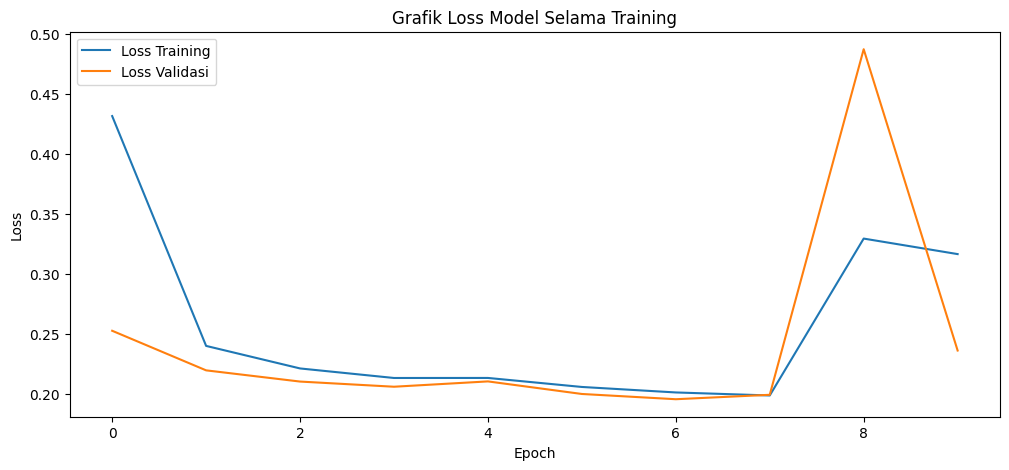

In [54]:
# ==============================================================================
# 4. VISUALISASI HASIL TRAINING (OPSIONAL TAPI BERGUNA)
# ==============================================================================
print("\n--- Langkah 4: Visualisasi Hasil Training ---")
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Grafik Loss Model Selama Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('grafik_loss_model.png')
plt.show()
# ... (setelah blok kode VISUALISASI HASIL TRAINING) ...

In [55]:
# ==============================================================================
# 5. EVALUASI DETAIL PADA DATA VALIDASI
# ==============================================================================
print("\n--- Langkah 5: Evaluasi Detail Model ---")
from sklearn.metrics import classification_report

# Lakukan prediksi pada data validasi
y_pred_raw = model.predict(X_val)
# Ubah hasil probabilitas menjadi kelas prediksi (0-8)
y_pred = np.argmax(y_pred_raw, axis=2)

# Definisikan nama kelas untuk laporan
nama_kelas = [
    'Tidak Hujan', 'Hujan dari Utara', 'Hujan dari Timur Laut',
    'Hujan dari Timur', 'Hujan dari Tenggara', 'Hujan dari Selatan',
    'Hujan dari Barat Daya', 'Hujan dari Barat', 'Hujan dari Barat Laut'
]

# Karena ini adalah model multi-output, mari kita evaluasi setiap langkah prediksi
# y_val -> (jumlah_sampel, 4 langkah prediksi)
# y_pred -> (jumlah_sampel, 4 langkah prediksi)
for i, langkah in enumerate([5, 10, 15, 20]):
    print(f"\n===== Laporan Klasifikasi untuk Prediksi +{langkah} Menit =====")
    # Ambil semua prediksi dan target untuk langkah waktu ke-i
    print(classification_report(
        y_val[:, i], 
        y_pred[:, i],
        labels=range(9),
        target_names=nama_kelas,
        zero_division=0
    ))


--- Langkah 5: Evaluasi Detail Model ---
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

===== Laporan Klasifikasi untuk Prediksi +5 Menit =====
                       precision    recall  f1-score   support

          Tidak Hujan       0.94      1.00      0.97      5359
     Hujan dari Utara       0.88      0.21      0.33       184
Hujan dari Timur Laut       0.00      0.00      0.00         0
     Hujan dari Timur       0.00      0.00      0.00         0
  Hujan dari Tenggara       0.00      0.00      0.00         0
   Hujan dari Selatan       0.00      0.00      0.00         0
Hujan dari Barat Daya       0.00      0.00      0.00         0
     Hujan dari Barat       0.00      0.00      0.00         0
Hujan dari Barat Laut       0.84      0.23      0.36       246

             accuracy                           0.94      5789
            macro avg       0.30      0.16      0.18      5789
         weighted avg       0.94      0.94      0.92      5789


===== Laporan Klasifikasi untuk Pred

In [56]:
# ==============================================================================
# 6. MENYIMPAN MODEL
# ==============================================================================

model.save(FILE_OUTPUT_MODEL)
print(f"Model telah disimpan sebagai '{FILE_OUTPUT_MODEL}'")

Model telah disimpan sebagai 'model_bilstm_cuaca.h5'
